In [1]:
%matplotlib inline
import os, sys
import numpy as np
import pandas as pd
from scipy import stats
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

RES_DIR = "/home/jingbozhou/Project/CombDrug/runAddMut/8-analysis/result/resData/"

In [2]:
cancer_type = "All"

ZIP_res = pd.read_csv(os.path.join(RES_DIR, "{}_ZIP_1.csv").format(cancer_type))
ZIP_res = ZIP_res.drop_duplicates(subset=["sign_effectsize", "p_value"])

Bliss_res = pd.read_csv(os.path.join(RES_DIR, "{}_Bliss_1.csv").format(cancer_type))
Bliss_res = Bliss_res.drop_duplicates(subset=["sign_effectsize", "p_value"])

Loewe_res = pd.read_csv(os.path.join(RES_DIR, "{}_Loewe_1.csv").format(cancer_type))
Loewe_res = Loewe_res.drop_duplicates(subset=["sign_effectsize", "p_value"])

HSA_res = pd.read_csv(os.path.join(RES_DIR, "{}_HSA_1.csv").format(cancer_type))
HSA_res = HSA_res.drop_duplicates(subset=["sign_effectsize", "p_value"])

def getSigRes(data, syn_name):
    data_sig = data[(data["p_value"]<=0.001)&(data["FDR"]<=0.05)&(np.abs(data["sign_effectsize"])>=2)].copy()
    data_sig["Synergy_name"] = syn_name
    
    data_no = data[~((data["p_value"]<=0.001)&(data["FDR"]<=0.05)&(np.abs(data["sign_effectsize"])>=2))]
    return data_sig, data_no

ZIP_sig, ZIP_no = getSigRes(ZIP_res, "ZIP")
Bliss_sig, Bliss_no = getSigRes(Bliss_res, "Bliss")
Loewe_sig, Loewe_no = getSigRes(Loewe_res, "Loewe")
HSA_sig, HSA_no = getSigRes(HSA_res, "HSA")

In [3]:
data_sig = pd.concat([ZIP_sig, Bliss_sig, Loewe_sig, HSA_sig], axis=0)

data_no = pd.concat([ZIP_no, Bliss_no, Loewe_no, HSA_no], axis=0)
data_no = data_no[(data_no["p_value"]>data_sig["p_value"].min())&\
                  (data_no['sign_effectsize']<data_sig["sign_effectsize"].max())&\
                  (data_no['sign_effectsize']>data_sig["sign_effectsize"].min())].copy()

tmp_a = data_no[(data_no["p_value"]<0.001)|(abs(data_no["sign_effectsize"])>=1)].sample(frac=0.1)
tmp_b = data_no[~((data_no["p_value"]<0.001)|(abs(data_no["sign_effectsize"])>=1))].sample(len(tmp_a))
data_no = pd.concat([tmp_a, tmp_b], axis=0)
data_no["Synergy_name"] = "Not Sig."


data_sel = pd.concat([data_sig[['p_value', 'sign_effectsize', 'Synergy_name']], 
                      data_no[['p_value', 'sign_effectsize', 'Synergy_name']]], axis=0).copy()

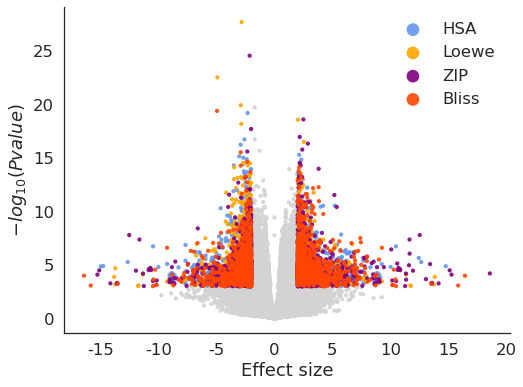

In [4]:
effect_thr=2
pvalue_thr=0.001,
col_map_d = {"Not Sig.":"lightgrey",
             'HSA':"cornflowerblue", 
             'Loewe':"orange", 
             'ZIP':"purple", 
             'Bliss':"orangered",}
#col_map_rev = {v:k for k, v in col_map_d.items()}

#data_sel = raw_data.copy()

#np.random.seed(0)
data_sel['log10pvalue'] = -(np.log10(data_sel["p_value"]))

# Set up regulated color
#data_sel['color_add_axy'] = data_sel["Synergy_name"].map(col_map_d)

sns.set(font_scale=1.5, rc={'figure.figsize':(8, 6), 
                          'axes.unicode_minus':False}, 
        style="white")

fig, ax = plt.subplots()
for key, value in col_map_d.items():
    data_plot = data_sel[data_sel['Synergy_name']==key]
    if key != "Not Sig.":
        ax.scatter(data_plot["sign_effectsize"], 
                   data_plot['log10pvalue'], 
                   c=value, label=key,
                   alpha=0.9, s=18, marker="o", edgecolor='none')
    else:
        ax.scatter(data_plot["sign_effectsize"], 
                   data_plot['log10pvalue'], 
                   c=value,
                   alpha=0.9, s=18, marker="o", edgecolor='none')
        
    
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.xlabel("Effect size", fontsize=18)
plt.ylabel("$-log_{10}(Pvalue)$", fontsize=18)
ax.legend(frameon=False,  markerscale=3.)

#plt.savefig("./plotRes/all_volcance.pdf", bbox_inches="tight")